# Table of contents
1. [Introduction](#introduction)
2. [Import](#import)
3. [Data preprocessing](#preprocess)
    1. [Missing values](#subpreprocess)
4. [Correlation with dependent variable](#correlation_dependent)
5. [Feature engineering](#feature_engineering)
    1. [One-hot encoding](#one-hot)
6. [Importance of variables](#importance)
    1. [Correlation between variables with highest importance score](#correlation_importance)
    2. [Variables selection](#variables_selection)
7. [Scaling data](#scaling)
8. [Train-test split](#train_test)
9. [Base estimator - linear regression](#base_estimator)
10. [Xgboost](#xgboost)
11. [Summary and future plan](#summary)

## Intruduction <a name="introduction"></a>

Data analysis of "House Prices: Advanced Regression Techniques" Kaggle challenge is presented.
<br>
It is the second most popular (after Titanic survival) challenge on Kaggle.
The main difference between these two is the fact that in case of house pricing we are given a regression problem
as opposed to classification probl in case of Titanic challenge. My main goal here was to explore xgboost and 
Bayesian optimisation of hyperparameters with the use of hyperopt package as well as data presentation aspects
using seaborn package.

## Importing packages and data <a name="import"></a>

In [1]:
import pandas as pd
import numpy as np
import os
import scipy as sp
import matplotlib
matplotlib.use('Qt4Agg')
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV, LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import warnings
from utils import plot_learning_curve
%matplotlib inline
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import pickle
from utils import plot_learning_curve

Changing the fontisize for all graphs so that everything is (hopefully) clearly visible

In [3]:
font = {'size' : 15}

matplotlib.rc('font', **font)

In [56]:
data_house = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')

## Data preprocessing <a name="preprocess"></a>

### Missing values <a name="subpreprocess"></a>
This is a sub paragraph, formatted in heading 3 style

We are going to check the count and percentage of missing values in the dataset

In [5]:
missing = data_house.isnull().sum().sort_values(ascending=False)
percent = data_house.isnull().sum()/data_house.isnull().count().sort_values(ascending=False)
data_missing = pd.concat([missing, percent], axis=1, keys=['Total', 'Percent']).sort_values(by='Total', ascending=False)
print(data_missing.head(6))

             Total   Percent
PoolQC        1453  0.995205
MiscFeature   1406  0.963014
Alley         1369  0.937671
Fence         1179  0.807534
FireplaceQu    690  0.472603
LotFrontage    259  0.177397


Plot missing variables in descending order, results are shown only for those variables that do possess some NaNs.

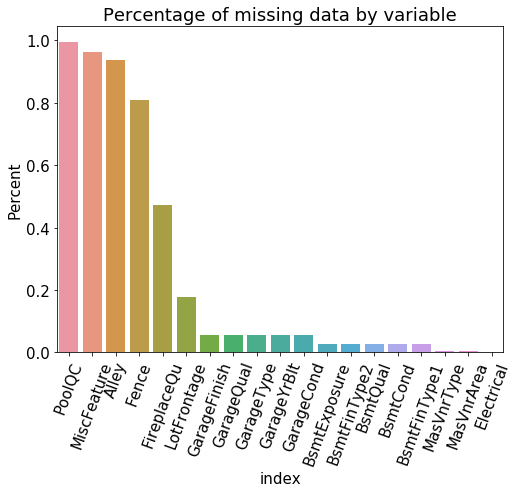

In [6]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(8,6))
sns.barplot(data=data_missing[data_missing['Percent'] >0].reset_index(), x = 'index', 
            y='Percent')
plt.xticks(rotation=70)
plt.title("Percentage of missing data by variable")
plt.show()

Drop variables when more than 90% of data is missing

In [7]:
data_house.drop(data_missing[data_missing['Percent']>0.7].index,1, inplace=True)

Based on description file.txt most of the missing data in variables such as Fence, Garage or Bsmt connected variables
are due to the lack of fence, garage etc. Due ot this fact we can fill NA in those variables with new category (since they are categorical variables)
For the data that is numeric the filled values are equal to zero - also due to the fact that apparent absence of values of these variables is connected with missing data.

In [8]:
data_house.loc[:,data_house.columns.str.contains
("Garage|Bsmt|Fence|MasVnrType|Electrical|FireplaceQu")] = data_house.loc[:,
data_house.columns.str.contains("Garage|Bsmt|Fence|MasVnrType|Electrical|FireplaceQu")].fillna("MISSING")
data_house.loc[:,["MasVnrArea", "LotFrontage"]] = data_house.loc[:,["MasVnrArea", "LotFrontage"]].fillna(0)

Checking uniqueness of Id variable, assigned to each sold house

In [85]:
if len(set(data_house['Id'])) == len(data_house['Id']):
    print("Id is the key!")

Id is the key!


Distribution of the target variable

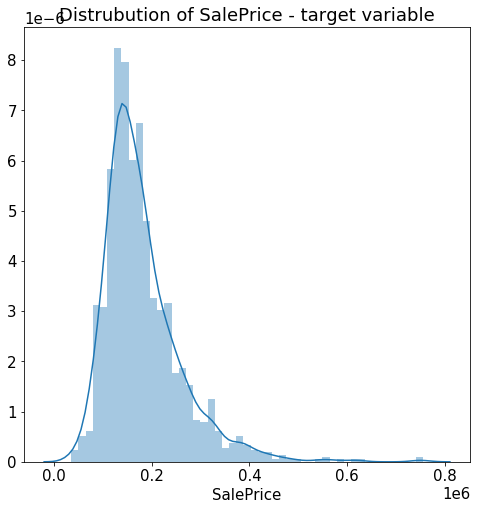

Skewness: 1.8828757597682129
Kurtosis: 6.536281860064529


In [9]:
fig, ax = plt.subplots(figsize=(8,8))
sns.distplot(data_house['SalePrice'])
ax.set_title("Distrubution of SalePrice - target variable")
ax.ticklabel_format(style='scientific', axis='both', scilimits=(-3,3))
plt.show()
skew = data_house['SalePrice'].skew()
kurt = data_house['SalePrice'].kurt()
print(f'Skewness: {skew}\nKurtosis: {kurt}')

Fiew visualisations to show basic relationships and statistics

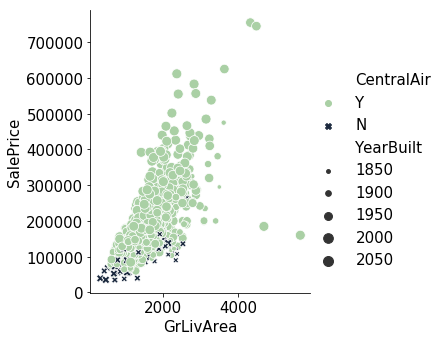

In [10]:
sns.relplot(x = 'GrLivArea', y = 'SalePrice', hue = 'CentralAir', style='CentralAir', 
            palette= "ch:r=-.5,l=0.75", size="YearBuilt", sizes=(15,100), data = data_house)
plt.show()

We can see that there are outliers present, with GrLivArea higher than 4000 square feet
<br>
They can be removed without further ado (based on description of some Kaggle kernels it was mentioned before in the
documentation of the challenge)


In [12]:
data_house = data_house[data_house['GrLivArea'] <4000]

In [13]:
data_mean = data_house.groupby(by='YearBuilt').agg('mean')
data_mean.reset_index(inplace=True)

Show average SalePrice by year. The shady area around the graph is standard deviation of mean for each year

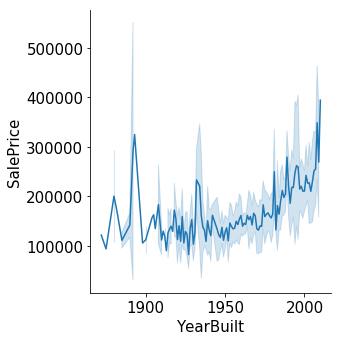

In [62]:
sns.relplot(x='YearBuilt', y = 'SalePrice', kind='line', ci='sd', estimator = 'mean',data=data_house)
plt.show()

We are going to check how does the price distribute based on overall condition of the house.
<br>
One can suspect that the better the quality of the same the bigger the price.
<br>
Firstly we are going to check basic statics for each condition rating, that is mean, count and standard deviation

In [69]:
data_grouped = data_house.groupby(by='OverallCond').agg(['mean', 'count', 'std'])['SalePrice']

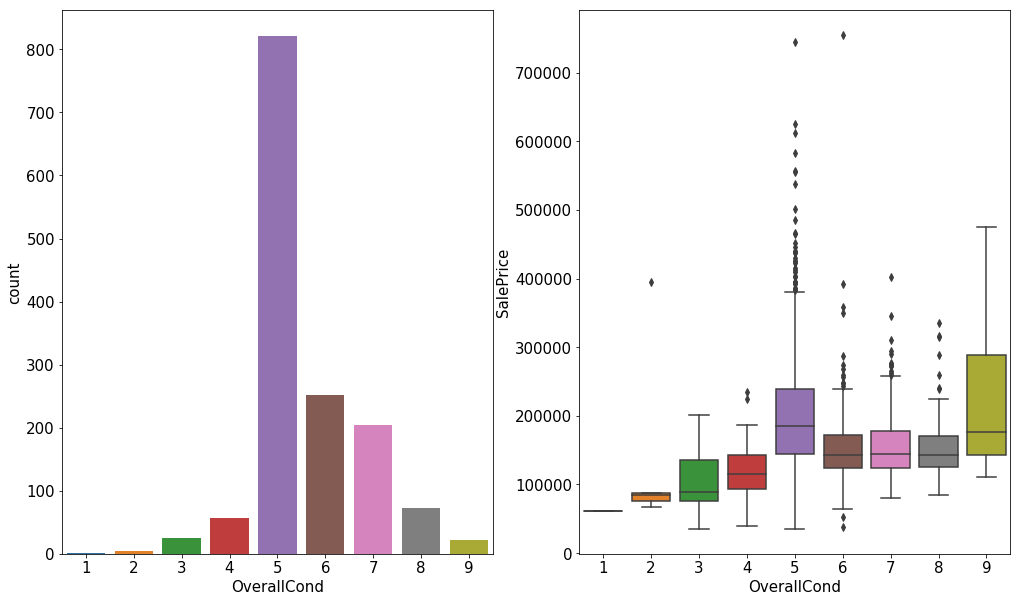

In [78]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(17, 10))
axes = axes.flatten()
sns.barplot(x='OverallCond', y='count', data=data_grouped.reset_index(), ax = axes[0])
sns.boxplot(x = 'OverallCond', y='SalePrice', data=data_house, ax = axes[1])

The most popular rating of the house overall condition was 5. It is clearly visible that very few houses
with condition rated less than 4 were sold.
<br>
Moreover there is not clearly visible indication that overall quality affects average price so much, although it may
be due to the fact that we do not have infromation about location of these houses

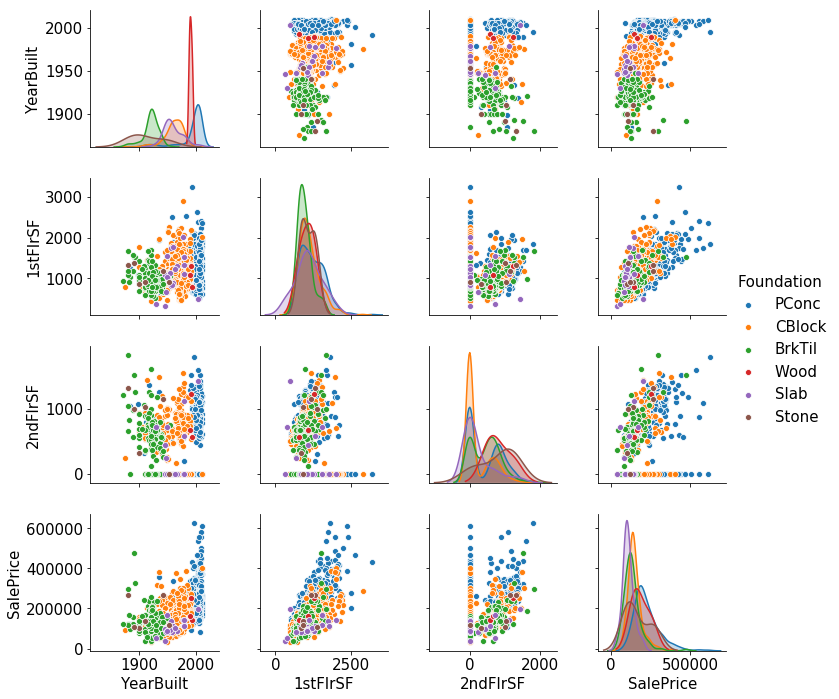

In [17]:
sns.pairplot(data=data_house, x_vars=['YearBuilt','1stFlrSF', '2ndFlrSF','SalePrice'],
             y_vars=['YearBuilt','1stFlrSF', '2ndFlrSF','SalePrice'], hue='Foundation')
plt.show()

Funny thing to spot is the change of main foundation material that was used to built houses, with the highlights
in following order:
* Brick (in 30s and 40s)
* Cinder block and Slab (in second half of 20th century)
* Wood (sharp peak around year 2000)
* Concrete (in 21st century)

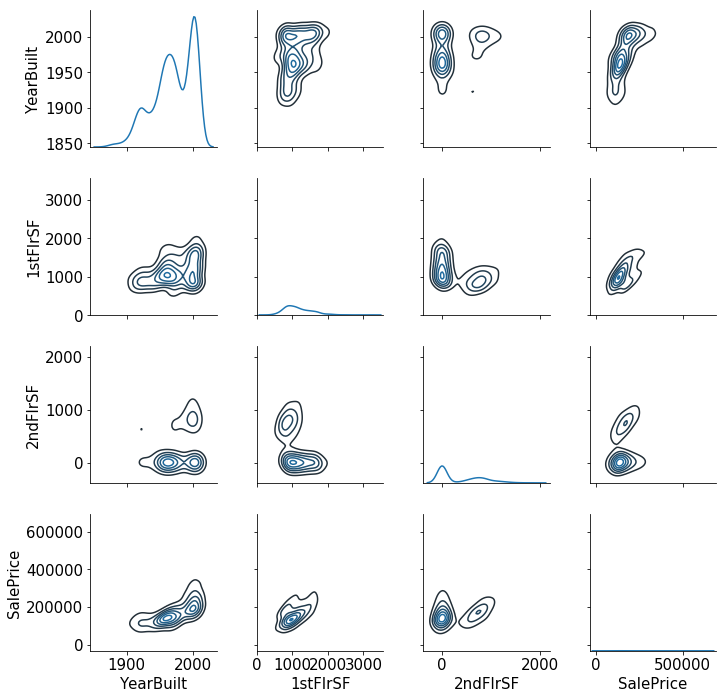

In [18]:
g = sns.PairGrid(data_house,x_vars=['YearBuilt','1stFlrSF', '2ndFlrSF','SalePrice'],
             y_vars=['YearBuilt','1stFlrSF', '2ndFlrSF','SalePrice'])
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot, n_levels=6);

One can easily spot changes in the type of materials used to build houses throughout given time period.

Now it's time to check correlations between dependent variable and the rest

### Correlation with dependent variable <a name="correlation_dependent"></a>

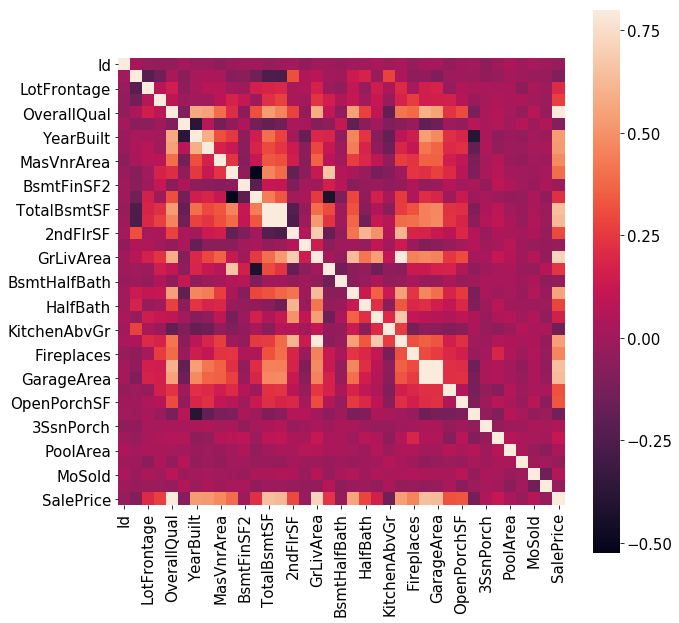

In [19]:
corrmat = data_house.corr()
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(data=corrmat, vmax=.8, square=True)
plt.show()

Print only 10 mostly correlated variables

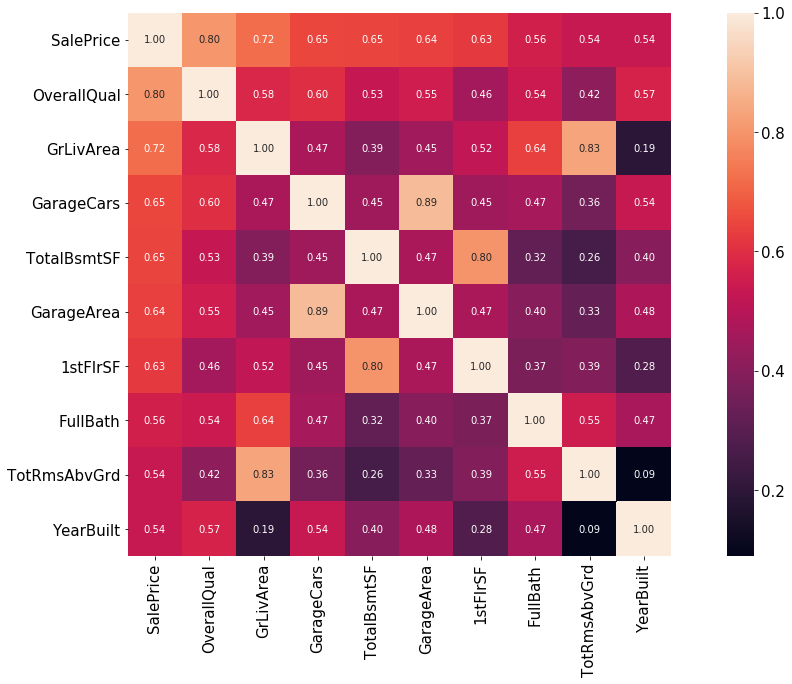

In [20]:
fig, ax = plt.subplots(figsize=(20,10))
cols = corrmat.nlargest(10, 'SalePrice')['SalePrice'].index
corr10 = data_house.loc[:, cols].corr()
sns.heatmap(data=corr10, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10})
plt.show()

### Feature engineering <a name="feature_engineering"></a>

It's reasonable to define Age variable instead of YearBuilt, since during scaling year differences
<br>
would be insignificant compared to differences in house ages
<br>
since the newest records are from year 2010, I'm going to assume that the dataset is from 2011 and based on that 
calculate the Age variable

In [21]:
data_house['Age'] = 2011 - data_house['YearBuilt']

### One-hot encoding <a name="one-hot"></a>

One-hot encoding of the character variables
<br>
Semicolon added to surpress output

In [22]:
pd.get_dummies(data_house.select_dtypes('object'));
data_house_one_hot = pd.concat([data_house.select_dtypes(['int','float']),
                                pd.get_dummies(data_house.select_dtypes('object'))], axis=1)

### Importance of variables <a name="importance"></a>

Importance selection based on RandomForest result and one-hot encoded data

In [23]:
rf = RandomForestRegressor(n_estimators=100, min_samples_leaf=5, random_state=42)

In [24]:
X_rf = data_house_one_hot.columns.isin(["SalePrice","Id"])
rf.fit(X=data_house_one_hot.loc[:, ~X_rf], 
       y = data_house_one_hot.loc[:,"SalePrice"])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=5, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [25]:
importances = pd.concat([pd.Series(data_house_one_hot.columns[~X_rf]),
                         pd.Series(rf.feature_importances_)], axis=1)

In [26]:
importances_dict = dict(zip(data_house_one_hot.columns[~X_rf],rf.feature_importances_))

In [27]:
importances.columns = ['Feature', "Importance"]
importances_sorted = importances.sort_values(by="Importance",ascending=False)

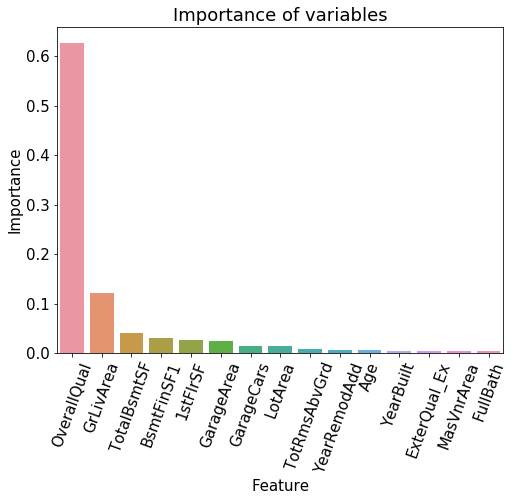

In [28]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(8,6))
sns.barplot(data=importances_sorted.iloc[:15,:],
            x = "Feature",
            y='Importance')
plt.xticks(rotation=70)
plt.title("Importance of variables")
plt.show()

Calculate correlation matrix between 15 variables with highest importance from randomforest

### Correlation between variables with highest importance score <a name="correlation_importance"></a>

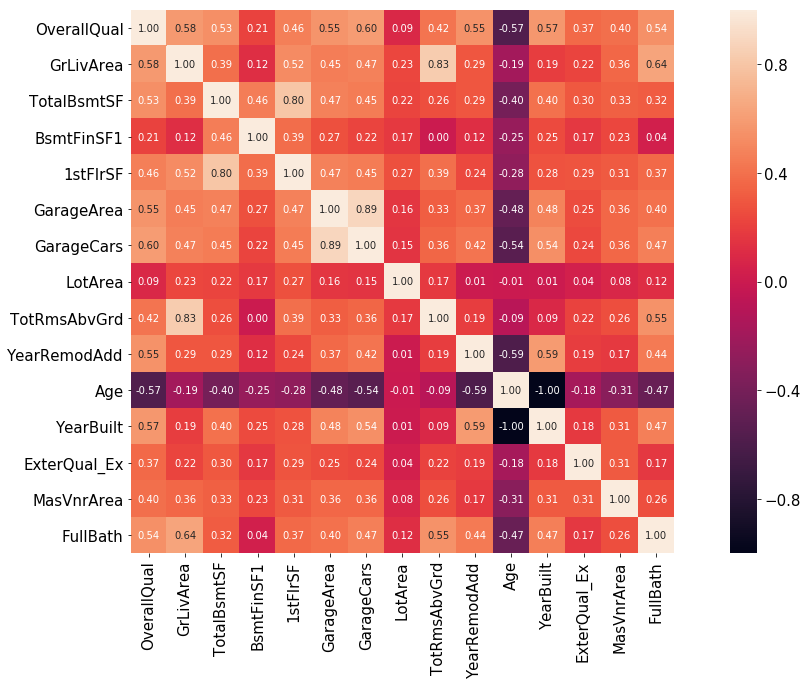

In [29]:
fig, ax = plt.subplots(figsize=(20,10))
correlations = data_house_one_hot.loc[:,importances_sorted.iloc[:15,:]['Feature']].corr()
sns.heatmap(correlations, annot=True, square=True,
           fmt='.2f', annot_kws = {'size': 10})

### Variables selection <a name="variables_selection"></a>

Select only pairs with higher correlation than threshold given in np.triu function

In [30]:
corr_matrix = correlations.abs()
index_names = corr_matrix.index
col_names = corr_matrix.columns
arr = corr_matrix.values
R,C = np.where(np.triu(arr,1)>0.7)

# Arrange those in columns and put out as a dataframe
out_arr = np.column_stack((index_names[R],col_names[C],arr[R,C]))
df_out = pd.DataFrame(out_arr,columns=[['row_name','col_name','value']])

Select columns to drop from the list of 15 most important from random forest that are correalted
<br>
more than threshold given in previous cell

In [31]:
cols_to_drop = []
for var in out_arr:
    temp = dict( (k,importances_dict[k]) for k in [var[0],var[1]] if k in importances_dict.keys())
    cols_to_drop.append(min(temp, key=temp.get))

In [32]:
variables = corr_matrix.columns.drop(cols_to_drop)

Define data with selected variables

In [33]:
data_house_selected = pd.concat([data_house_one_hot.loc[:,variables], data_house['SalePrice']], axis=1)

### Scaling data <a name="scaling"></a>

In [34]:
minmax = MinMaxScaler()
minmax.fit(data_house_selected)
data_house_selected_norm = pd.DataFrame(minmax.transform(data_house_selected), index=data_house_selected.index,
                                        columns=data_house_selected.columns)

/Users/lukaszbala/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


### Train-test split <a name="train_test"></a>

Split train.csv into test and dev set to see how the model is doing directly

In [35]:
data_house_selected_norm_x = data_house_selected_norm.loc[:,~data_house_selected_norm.columns.isin(['SalePrice'])]
train_x, dev_x, train_y, dev_y = train_test_split(data_house_selected_norm_x, 
                                                  data_house_selected_norm['SalePrice'], 
                                                    test_size=0.2, random_state=42)

### Base estimator - linear regression <a name="base_estimator"></a>

In [36]:
lr = LinearRegression()
lr.fit(train_x, train_y)
lr_pred = lr.predict(dev_x)
print(np.sqrt(mean_squared_error(y_pred=lr_pred, y_true=dev_y)))

0.04678890770434552


<module 'matplotlib.pyplot' from '/Users/lukaszbala/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

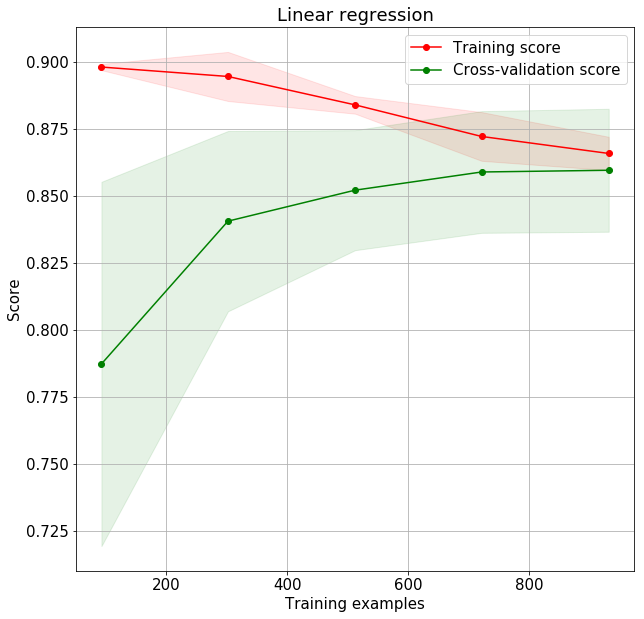

In [37]:
plot_learning_curve(X=train_x, y = train_y, estimator=lr, cv=5, title="Linear regression")

### Xgboost <a name='xgboost'></a>

Using xgboost and comparing without and with hyperopt

In [38]:
dtrain = xgb.DMatrix(train_x, label=train_y)
ddev = xgb.DMatrix(dev_x, label=dev_y)

In [39]:
param = {'objective': 'reg:linear', 'eval_metric': 'rmse', 'base_score' : 0.5, 'booster' : 'gbtree', 
         'colsample_bylevel' : 1, 'colsample_bytree':1, 'learning_rate':0.1, 'max_delta_step':0,
         'min_child_weight':1, 'missing':None, 'n_estimators':100,
       'n_jobs':1, 'random_state':0,
       'reg_alpha':0, 'reg_lambda':1, 'scale_pos_weight':1,
       'silent':True, 'subsample':1, 'seed':42}
evallist = [(ddev, 'eval'), (dtrain, 'train')]
num_round=1000

In [40]:
bst = xgb.train(param, dtrain, num_round, evallist, verbose_eval=200)

[0]	eval-rmse:0.261618	train-rmse:0.256824
[200]	eval-rmse:0.043059	train-rmse:0.0065
[400]	eval-rmse:0.04297	train-rmse:0.00228
[600]	eval-rmse:0.042946	train-rmse:0.002029
[800]	eval-rmse:0.042946	train-rmse:0.002029
[999]	eval-rmse:0.042946	train-rmse:0.002029


In [41]:
xgbregr = xgb.XGBRegressor(seed=42)
xgbregr.fit(train_x, train_y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=1)

In [42]:
pred = xgbregr.predict(dev_x)

In [43]:
pred2 = bst.predict(ddev)

Results without hyperopt - XGBRegressor and xgb.train compared

In [44]:
print(np.sqrt(mean_squared_error(y_pred=pred, y_true=dev_y)))
print(np.sqrt(mean_squared_error(y_pred=pred2, y_true=dev_y)))

0.04131356630872501
0.04294602714136356


<module 'matplotlib.pyplot' from '/Users/lukaszbala/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

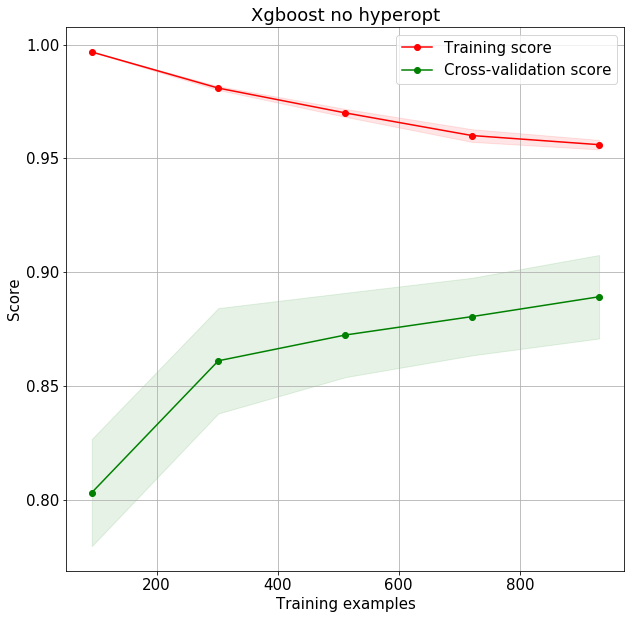

In [45]:
plot_learning_curve(X=train_x, y = train_y, estimator=xgbregr, cv=5, title="Xgboost no hyperopt")

Defining objective function and range for some parametrs to be used in hyperopt

In [46]:
def objective(space):
    clf = xgb.XGBRegressor(n_estimators =1000,colsample_bytree=space['colsample_bytree'],
                           learning_rate = .3,
                            max_depth = int(space['max_depth']),
                            min_child_weight = space['min_child_weight'],
                            subsample = space['subsample'],
                           gamma = space['gamma'],
                           reg_lambda = space['reg_lambda'])

    eval_set  = [( train_x, train_y), ( dev_x, dev_y)]

    clf.fit(train_x, train_y,
            eval_set=eval_set, eval_metric="rmse",
            early_stopping_rounds=10,verbose=False)

    pred = clf.predict(dev_x)
    mse_scr = mean_squared_error(dev_y, pred)
    #change the metric if you like
    return {'loss':mse_scr, 'status': STATUS_OK }


space ={'max_depth': hp.quniform("x_max_depth", 1, 13, 1),
        'min_child_weight': hp.quniform ('x_min_child', 1, 10, 1),
        'subsample': hp.uniform ('x_subsample', 0.7, 1),
        'gamma' : hp.uniform ('x_gamma', 0.,0.5),
        'colsample_bytree' : hp.uniform ('x_colsample_bytree', 0.4,1),
        'reg_lambda' : hp.uniform ('x_reg_lambda', 0,1),
        'colsample_bylevel': hp.uniform('x_colsample_bylevel',0.4,1),
        'colsample_bynode' : hp.uniform('x_colsample_bynode',0.4,1),
        'reg_alpha': hp.uniform('x_reg_alpha',0,1)
        
    }


trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=1000,
            trials=trials)

In [47]:
# The trials database now contains 100 entries, it can be saved/reloaded with pickle or another method
pickle.dump(trials, open("trials.pickle", "wb"))
trials = pickle.load(open("trials.pickle", "rb"))

# Perform an additional 100 evaluations
# Note that max_evals is set to 200 because 100 entries already exist in the database
best = fmin(objective,
    space=space,
    algo=tpe.suggest,
    trials=trials,
    max_evals=200)

In [48]:
param = {'objective': 'reg:linear', 'eval_metric': 'rmse', 'base_score' : 0.5, 'booster' : 'gbtree', 
         'colsample_bylevel' : 1, 'learning_rate':0.1, 'max_delta_step':0,
         'missing':None, 'n_estimators':100,
       'n_jobs':1, 'random_state':0,
       'reg_alpha':0, 'scale_pos_weight':1,
       'silent':True, 'subsample':1, 'seed':42, 'max_depth':int(best['x_max_depth']), 'gamma':best['x_gamma'],
        'reg_lambda':best['x_reg_lambda'],'subsample':best['x_subsample'], 
         'colsample_bytree':best['x_colsample_bytree'], 'min_child_weight':int(best['x_min_child'])}
evallist = [(ddev, 'eval'), (dtrain, 'train')]
num_round=1000

In [49]:
xgb_hyperopt = xgb.XGBRegressor(**param)

<module 'matplotlib.pyplot' from '/Users/lukaszbala/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

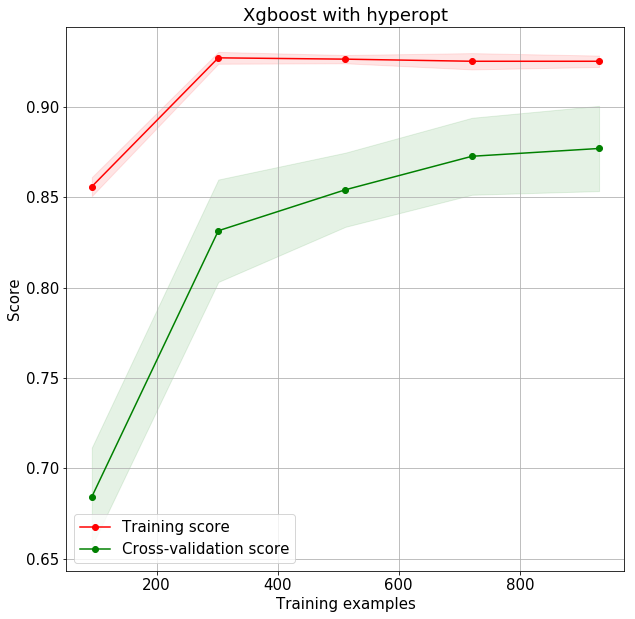

In [50]:
plot_learning_curve(X=train_x, y = train_y, estimator=xgb_hyperopt, cv=5, title="Xgboost with hyperopt")

In [51]:
xgb_hyperopt.fit(train_x, train_y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7716617058920461, eval_metric='rmse',
       gamma=0.03414496199641782, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=7, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=0.312922799527808, scale_pos_weight=1,
       seed=42, silent=True, subsample=0.9570902927555223)

In [52]:
print(np.sqrt(mean_squared_error(y_pred=xgb_hyperopt.predict(dev_x), y_true=dev_y)))

0.04408660800090644


It is surprising that the result is worse than the base XGBRegressor fit.
One should look into the dependence of results and obtained hyperparameters.
<br>
We are going to obtain dependency of loss vs hyperparameters by extracting these values
from "trials" object.

In [53]:
values = [key for key in list(trials)[0]['misc']['vals'].keys()]

loss_all = [x['result']['loss'] for x in list(trials)]
params_all = [[x['misc']['vals'][y][0] for x in list(trials)] for y in values]

In [54]:
params_hyperopt_df = pd.DataFrame([*params_all, loss_all]).T
params_hyperopt_df.columns = [*values, 'loss']

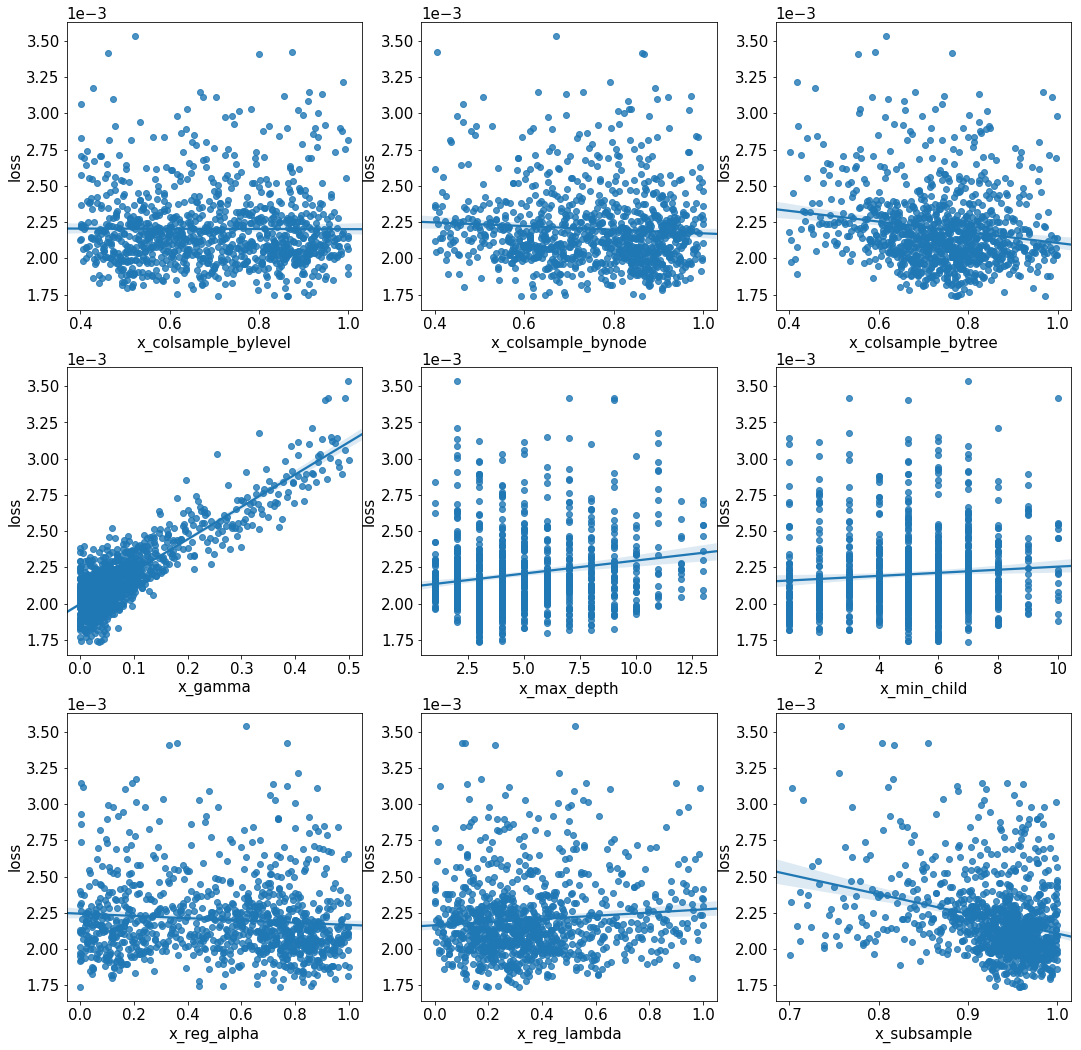

In [59]:
fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(18,18))
axes = axes.flatten()
plot_type = 'regplot'
for idx, ax in enumerate(axes):
    ax.ticklabel_format(style='sci')
    plt.sca(ax)
    try:
        getattr(sns, plot_type)(x=values[idx], y = 'loss', data=params_hyperopt_df)
        ax.ticklabel_format(style='scientific', scilimits=(-3,3))
    except AtributeError:
        print("Try different type of plot")
        raise

One can see that we can obtain lower loss by either:
*  decreasing x_colsample_bynode
*  increasing x_subsample

The rest of the parameters either do not seem to reduce loss or they even increase it when changed from default ones (like x_gamma)

### Summary and future plans <a name = "summary"></a>

Analysis of houses' sale prices was presented. With the use of xgboost 10% better accuracy as compared to linear regression was obtained for the same set of feautes. Furthermore xgboost with Bayesian optimisation was presnted, however no gain in predition was visible afterwards. <br>
Future plans consist of:
* Further exploration of hyperparameter tuning for xgboost
* Different types of encoding than one-hot for caterigocal variables
* Using transformation (like logarithmic) of target variable
* Model ensembling